In [17]:
from collections import defaultdict
import random

from loguru import logger

from camel_up.game import Camel, CamelUpGame, Player
from camel_up.strategies import AlwaysRollStrategy, TakeLeaderBetSlipStrategy

In [26]:
NUMBER_OF_GAMES = 100_000

In [27]:
%%capture

# Redirects loguru to stderr so that it is captured, otherwise the Jupyter notebooks crashes.
import sys
logger.remove()
logger.add(sys.stderr)

seed_value = 42
random.seed(seed_value)

number_of_legs = defaultdict(list)
player_scores = defaultdict(lambda: defaultdict(list))


for player_number in range(2,6):
    for _ in range(NUMBER_OF_GAMES):
    
        players: list[Player] = [
            Player(AlwaysRollStrategy()) for _ in range(player_number)
        ]
        camels: list[Camel] = [
            Camel(color=color) for color in ["red", "blue", "green", "purple", "yellow"]
        ]
        game: CamelUpGame = CamelUpGame(camels, players)
        while not game.is_game_finished():
            game.run_leg()
    
        number_of_legs[player_number].append(game.get_leg_number())
        
        for num, player in enumerate(game.players):
            player_scores[player_number][num].append(player.coins)
    

In [28]:
import pandas as pd

legs_data = []

for player_number, legs_list in number_of_legs.items():
    for legs in legs_list:
        legs_data.append({'player_number': player_number, 'number_of_legs': legs})
df_legs = pd.DataFrame(legs_data)        

/home/jay/projects/camel_up_python/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 8 x 6 in image.
/home/jay/projects/camel_up_python/.venv/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/distribution_of_number_of_legs.png


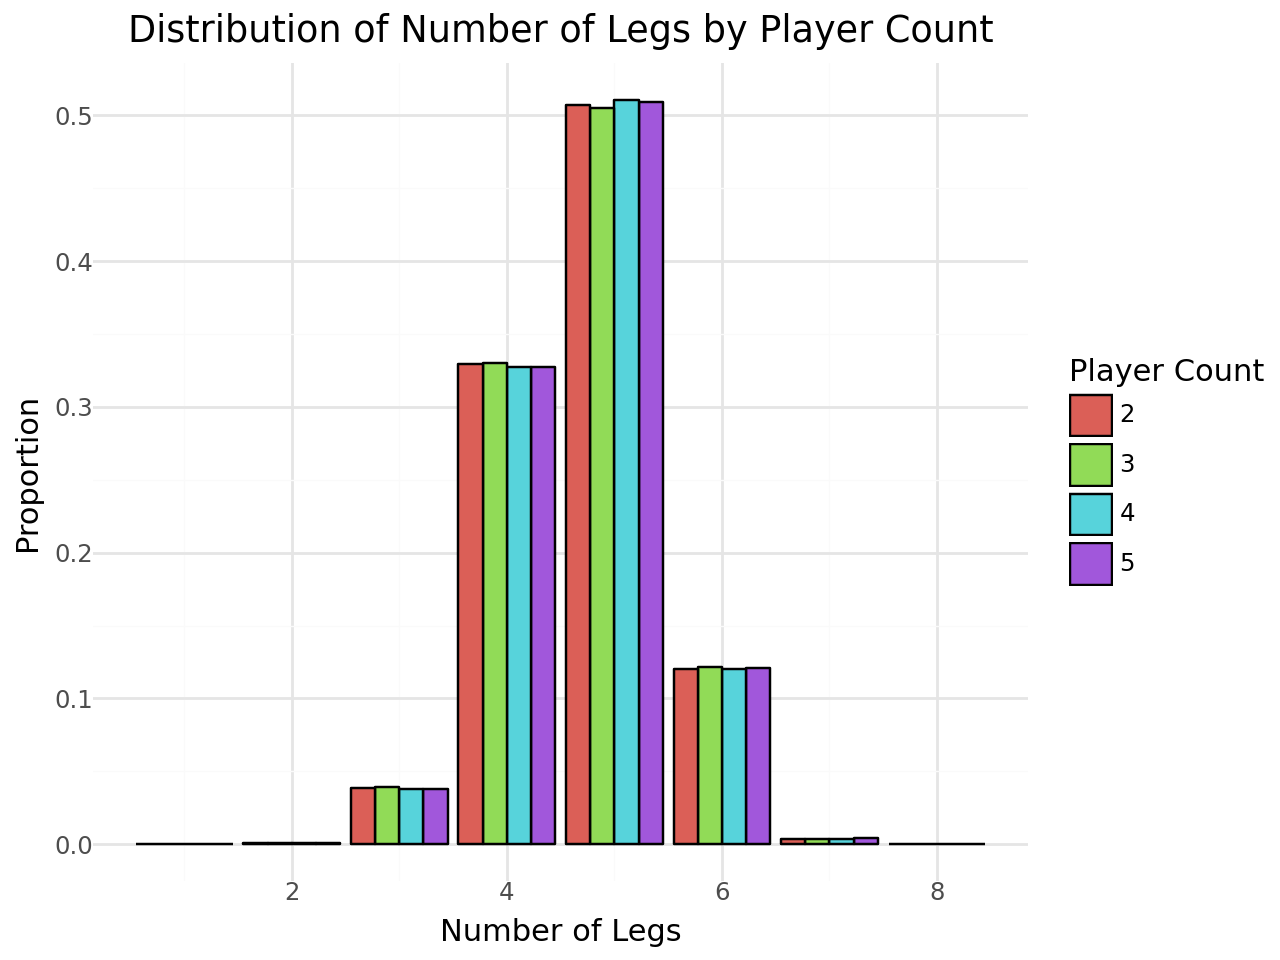

In [39]:
from plotnine import ggplot, aes, geom_histogram, theme_minimal, labs, geom_bar, ggtitle, ggsave


plot = (
    ggplot(df_legs, aes(x='number_of_legs', y='..prop..', fill='factor(player_number)')) 
    + geom_bar(stat='count', position='dodge',color='black')
    + labs(x="Number of Legs", y="Proportion", fill="Player Count")
    + ggtitle("Distribution of Number of Legs by Player Count")
    + theme_minimal()
)
ggsave(plot, filename='plots/distribution_of_number_of_legs.png', dpi=300, width=8, height=6, units='in')
plot

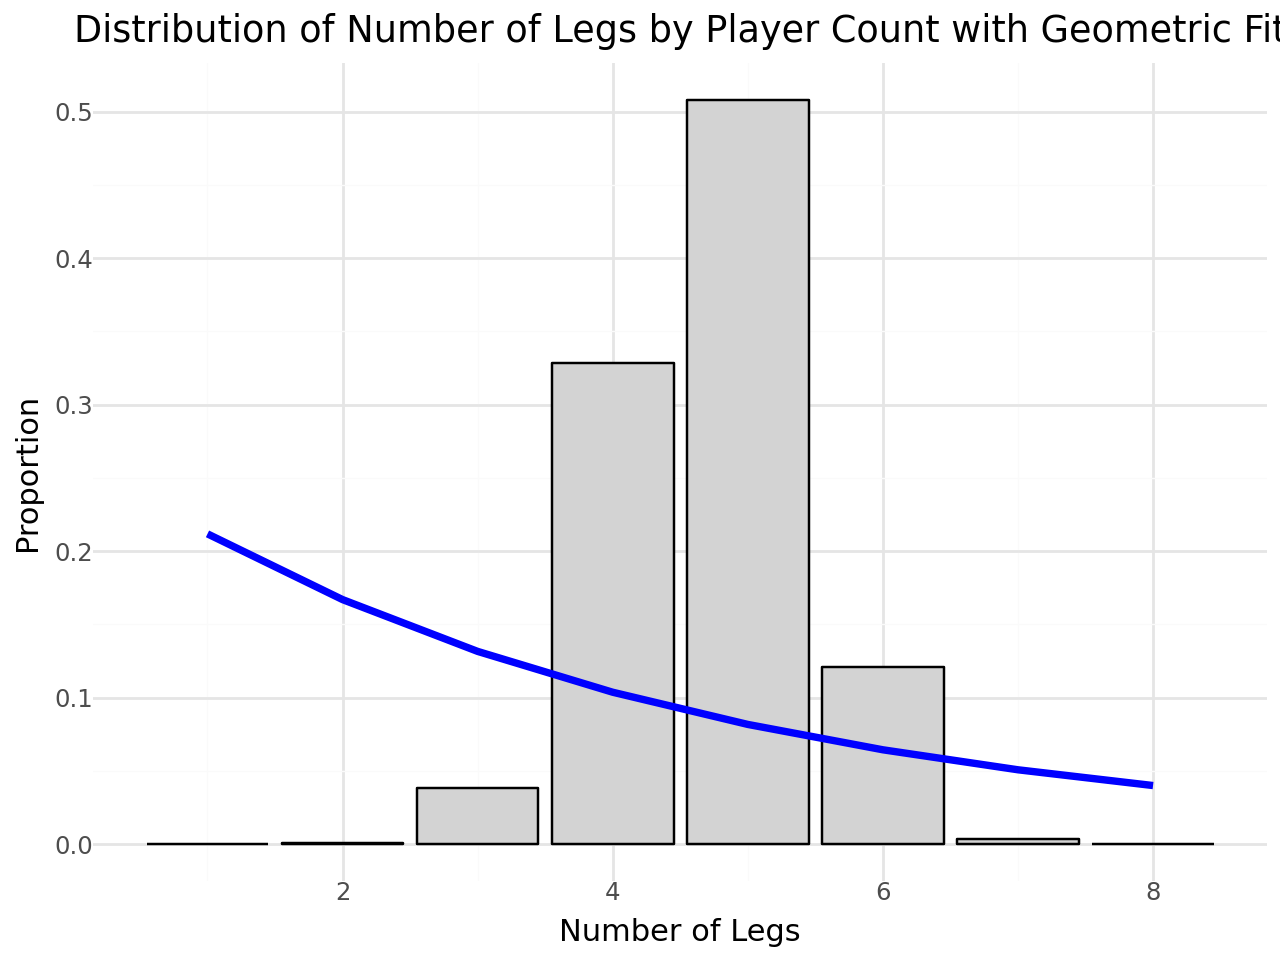

In [38]:
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_bar, geom_line, labs, ggtitle, theme_minimal
from scipy.stats import geom

# Convert the number_of_legs dictionary into a Pandas DataFrame
legs_data = []

for player_number, legs_list in number_of_legs.items():
    for legs in legs_list:
        legs_data.append({'player_number': player_number, 'number_of_legs': legs})

df_legs = pd.DataFrame(legs_data)

# Calculate the success probability (p) for the geometric distribution
# The mean of a geometric distribution is 1/p, so p = 1 / mean
mean_legs = df_legs['number_of_legs'].mean()
p = 1 / mean_legs

# Create a DataFrame for the geometric distribution curve
x_values = np.arange(1, df_legs['number_of_legs'].max() + 1)  # Geometric distribution starts from 1
geometric_probs = geom.pmf(x_values, p)

df_geometric = pd.DataFrame({'number_of_legs': x_values, 'probability': geometric_probs})

# Create the plot
plot = (
    ggplot(df_legs, aes(x='number_of_legs', y='..prop..')) 
    + geom_bar(stat='count', position='dodge', color='black', fill='lightgray')  # Histogram
    + geom_line(df_geometric, aes(x='number_of_legs', y='probability'),
                color='blue', size=1.5)  # Geometric curve
    + labs(x="Number of Legs", y="Proportion", fill="Player Count")
    + ggtitle("Distribution of Number of Legs by Player Count with Geometric Fit")
    + theme_minimal()
)

plot